Modelo de Clasificación de Casos de Dengue

Objetivo
Construir un modelo de machine learning que prediga la categoría de casos de dengue por rangos usando LightGBM.


Paso 1: Importaciones y carga de datos


In [42]:
# Celda 1
# Importacionesƒ
!pip3 install pandas numpy matplotlib seaborn scikit-learn lightgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb

print("Todo instalado")



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Todo instalado


In [43]:
#  Celda 2
#  Cargar datos
df = pd.read_csv('data-modelo.csv')

print(f"📊 Filas: {len(df):,}")
print(f"📋 Columnas: {len(df.columns)}")
print(f"\n🔍 Primeras 5 filas:")
df.head()


📊 Filas: 12,519
📋 Columnas: 38

🔍 Primeras 5 filas:


,id_uta,departamento_nombre,provincia_nombre,id_estacion,anio,semana,cantidad_casos,poblacion,temperatura_minima_lag1,temperatura_minima_lag2,...,tesion_vapor_media_lag3,radiacion_global_lag1,radiacion_global_lag2,radiacion_global_lag3,heliofania_efectiva_lag1,heliofania_efectiva_lag2,heliofania_efectiva_lag3,heliofania_relativa_lag1,heliofania_relativa_lag2,heliofania_relativa_lag3
0,2008,comuna 8,ciudad de buenos aires,A872810,2020,7,1.0,228953,21.042857,21.042857,...,23.412006,17.392447,17.392447,19.425206,6.938757,6.938757,7.937013,51.142857,51.142857,56.928571
1,2008,comuna 8,ciudad de buenos aires,A872810,2020,8,2.0,228953,17.695502,21.042857,...,24.017211,19.981907,17.392447,17.392447,7.841595,6.938757,6.938757,58.714286,51.142857,51.142857
2,2008,comuna 8,ciudad de buenos aires,A872810,2020,8,3.0,228953,14.612961,17.695502,...,24.017211,17.812327,19.981907,17.392447,6.905201,7.841595,6.938757,52.624060,58.714286,51.142857
3,2008,comuna 8,ciudad de buenos aires,A872810,2020,8,1.0,228953,14.612961,14.612961,...,18.818262,17.812327,17.812327,19.981907,6.905201,6.905201,7.841595,52.624060,52.624060,58.714286
4,2008,comuna 8,ciudad de buenos aires,A872810,2020,8,4.0,228953,14.612961,14.612961,...,15.009032,17.812327,17.812327,17.812327,6.905201,6.905201,6.905201,52.624060,52.624060,52.624060


In [44]:
# Celda 3
# Información básica del dataset
print("=" * 60)
print("INFORMACIÓN DEL DATASET")
print("=" * 60)
print(f"\n📅 Años: {df['anio'].min()} - {df['anio'].max()}")
print(f"📆 Semanas: {df['semana'].min()} - {df['semana'].max()}")
print(f"🏙️ Departamentos: {df['id_uta'].nunique()}")
print(f"🌍 Provincias: {df['provincia_nombre'].nunique()}")

print("\n" + "=" * 60)
print("CASOS DE DENGUE (cantidad_casos)")
print("=" * 60)
print(df['cantidad_casos'].describe())
print(f"\nTotal casos: {df['cantidad_casos'].sum():,.0f}")


INFORMACIÓN DEL DATASET

📅 Años: 2018 - 2025
📆 Semanas: 1 - 52
🏙️ Departamentos: 111
🌍 Provincias: 15

CASOS DE DENGUE (cantidad_casos)
count    12519.000000
mean        13.911495
std         31.427272
min          1.000000
25%          1.000000
50%          4.000000
75%         11.000000
max        433.000000
Name: cantidad_casos, dtype: float64

Total casos: 174,158


Paso 2: Analizar la distribución de casos para definir rangos

ANÁLISIS DE DISTRIBUCIÓN DE CASOS (INCLUYENDO CEROS)

🔍 Casos con 0 casos: 0 registros (0.0%)
🔍 Casos con >0 casos: 12,519 registros (100.0%)

📊 Estadísticas (incluyendo ceros):
count    12519.000000
mean        13.911495
std         31.427272
min          1.000000
25%          1.000000
50%          4.000000
75%         11.000000
max        433.000000
Name: cantidad_casos, dtype: float64

📈 Percentiles:
  10%: 1 casos
  25%: 1 casos
  50%: 4 casos
  75%: 11 casos
  90%: 34 casos
  95%: 64 casos
  99%: 160 casos


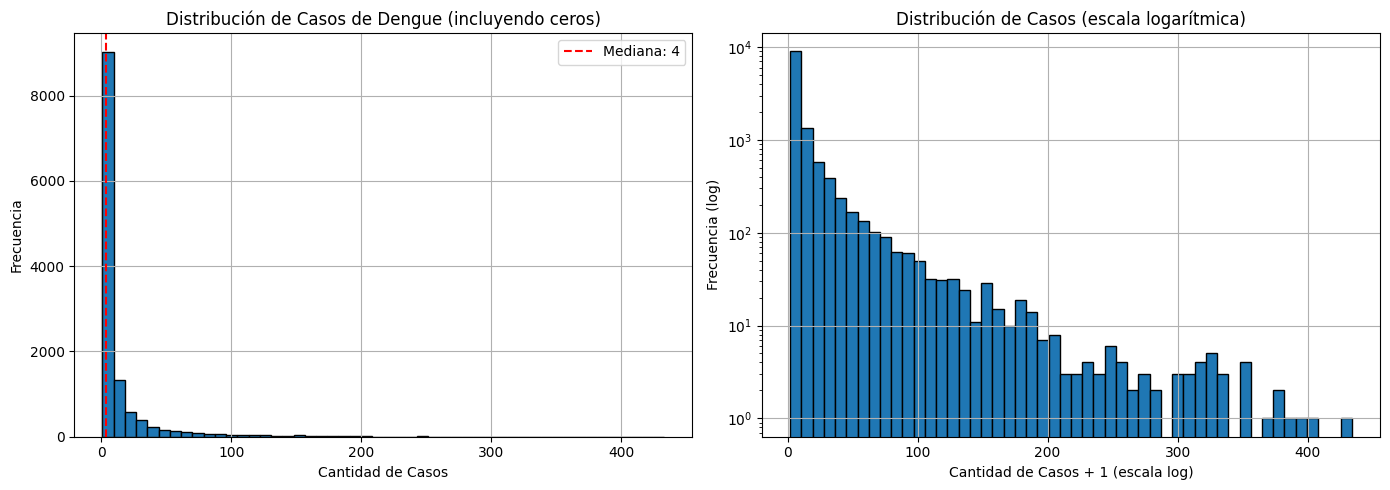

In [45]:
# Celda 4
# Análisis de distribución de casos INCLUYENDO CEROS
print("=" * 60)
print("ANÁLISIS DE DISTRIBUCIÓN DE CASOS (INCLUYENDO CEROS)")
print("=" * 60)

# Verificar si hay ceros
ceros = (df['cantidad_casos'] == 0).sum()
print(f"\n🔍 Casos con 0 casos: {ceros:,} registros ({ceros/len(df)*100:.1f}%)")
print(f"🔍 Casos con >0 casos: {(df['cantidad_casos'] > 0).sum():,} registros ({(df['cantidad_casos'] > 0).sum()/len(df)*100:.1f}%)")

# Estadísticas completas
print("\n📊 Estadísticas (incluyendo ceros):")
print(df['cantidad_casos'].describe())

# Percentiles específicos
percentiles = [10, 25, 50, 75, 90, 95, 99]
print("\n📈 Percentiles:")
for p in percentiles:
    valor = df['cantidad_casos'].quantile(p/100)
    print(f"  {p}%: {valor:.0f} casos")

# Visualización
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
df['cantidad_casos'].hist(bins=50, edgecolor='black')
plt.xlabel('Cantidad de Casos')
plt.ylabel('Frecuencia')
plt.title('Distribución de Casos de Dengue (incluyendo ceros)')
plt.axvline(df['cantidad_casos'].median(), color='r', linestyle='--', label=f'Mediana: {df["cantidad_casos"].median():.0f}')
plt.legend()

plt.subplot(1, 2, 2)
# Log scale para ver mejor la distribución (sumamos 1 para evitar log(0))
(df['cantidad_casos'] + 1).hist(bins=50, edgecolor='black', log=True)
plt.xlabel('Cantidad de Casos + 1 (escala log)')
plt.ylabel('Frecuencia (log)')
plt.title('Distribución de Casos (escala logarítmica)')

plt.tight_layout()
plt.show()

✅ Columna 'categoria_casos' creada.
      cantidad_casos  categoria_casos
1232             7.0                3
3623            36.0                5
8653            11.0                4
7931             2.0                1
6749             6.0                3

DISTRIBUCIÓN DE CATEGORÍAS DETALLADAS


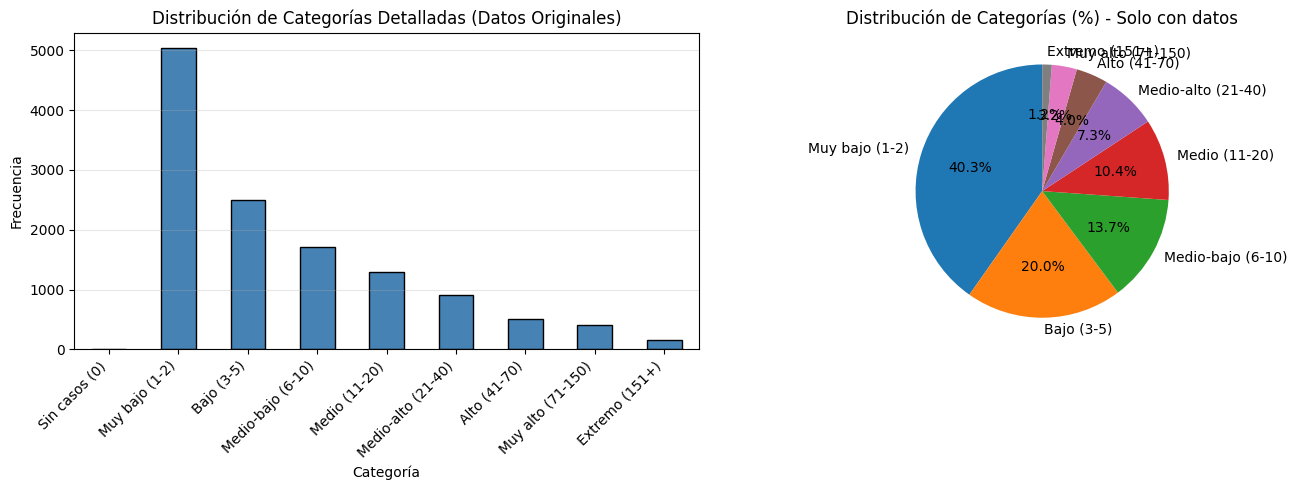


✅ Categorías detalladas creadas. Total de categorías definidas: 9 (0-8)
📊 Categorías con datos: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
📊 Rango de categorías en datos: 1 - 8


In [46]:
# Celda 5
# --- REEMPLAZO (Celda 5) ---
# 1. Definir la función para categorizar
# (Basada en tu diccionario 'categoria_nombres')

def categorizar_casos(casos):
    if casos == 0:
        return 0  # Sin casos (0)
    elif casos <= 2:
        return 1  # Muy bajo (1-2)
    elif casos <= 5:
        return 2  # Bajo (3-5)
    elif casos <= 10:
        return 3  # Medio-bajo (6-10)
    elif casos <= 20:
        return 4  # Medio (11-20)
    elif casos <= 40:
        return 5  # Medio-alto (21-40)
    elif casos <= 70:
        return 6  # Alto (41-70)
    elif casos <= 150:
        return 7  # Muy alto (71-150)
    else:
        return 8  # Extremo (151+)

# 2. Aplicar la función para crear la columna ANTES de graficar
df['categoria_casos'] = df['cantidad_casos'].apply(categorizar_casos)

print("✅ Columna 'categoria_casos' creada.")
print(df[['cantidad_casos', 'categoria_casos']].sample(5))

# 3. Ahora sí, graficamos (el código original de tu celda 5)
print("\n" + "=" * 60)
print("DISTRIBUCIÓN DE CATEGORÍAS DETALLADAS")
print("=" * 60)

categoria_nombres = {
    0: "Sin casos (0)", 1: "Muy bajo (1-2)", 2: "Bajo (3-5)",
    3: "Medio-bajo (6-10)", 4: "Medio (11-20)", 5: "Medio-alto (21-40)",
    6: "Alto (41-70)", 7: "Muy alto (71-150)", 8: "Extremo (151+)"
}

# (El resto de tu código de ploteo de la celda 5 está bien)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
conteos = df['categoria_casos'].value_counts().sort_index()
conteos_completos = pd.Series(index=range(9)).fillna(0)
conteos_completos.update(conteos)
conteos_completos.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de Categorías Detalladas (Datos Originales)')
plt.xticks(range(9), [categoria_nombres[i] for i in range(9)], rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
cats_con_datos = sorted(df['categoria_casos'].unique())
counts = [df['categoria_casos'].value_counts().sort_index()[cat] for cat in cats_con_datos]
labels = [categoria_nombres[cat] for cat in cats_con_datos]
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Categorías (%) - Solo con datos')
plt.tight_layout()
plt.show()

print(f"\n✅ Categorías detalladas creadas. Total de categorías definidas: 9 (0-8)")
print(f"📊 Categorías con datos: {sorted(df['categoria_casos'].unique())}")
print(f"📊 Rango de categorías en datos: {df['categoria_casos'].min()} - {df['categoria_casos'].max()}")

PASO 3: Rellenar dataset con todas las semanas (antes de crear lags)


In [47]:
# --- REEMPLAZO (Celda 6) ---
# Rellenar el dataset con todas las semanas

print("=" * 60)
print("RELLENANDO DATASET CON TODAS LAS SEMANAS")
print("=" * 60)

# 1. Crear índice completo
departamentos = df['id_uta'].unique()
años = df['anio'].unique()
semanas = range(1, 53)
index_completo = pd.MultiIndex.from_product(
    [departamentos, años, semanas],
    names=['id_uta', 'anio', 'semana']
)
df_completo = pd.DataFrame(index=index_completo).reset_index()

# 2. Hacer merge
df_completo = df_completo.merge(
    df,
    on=['id_uta', 'anio', 'semana'],
    how='left'
)

print(f"📊 Dataset original: {len(df):,} filas")
print(f"📊 Dataset completo (todas las semanas): {len(df_completo):,} filas")
print(f"📊 Semanas faltantes a rellenar: {len(df_completo) - len(df):,}")

# 3. Rellenar valores faltantes
print("\n📊 Rellenando valores faltantes...")
df_completo = df_completo.sort_values(['id_uta', 'anio', 'semana']).reset_index(drop=True)

# Llenar cantidad_casos con 0
df_completo['cantidad_casos'] = df_completo['cantidad_casos'].fillna(0)
print("  ✅ cantidad_casos: semanas faltantes = 0")

# Llenar 'categoria_casos' basado en 'cantidad_casos' (CORREGIDO)
df_completo['categoria_casos'] = df_completo['cantidad_casos'].apply(categorizar_casos)
print("  ✅ categoria_casos: recalculada")

# Columnas para ffill (todas menos las de ID, tiempo y targets)
# ¡CORREGIDO! 'key' eliminado de esta lista
columnas_a_rellenar = df.columns.drop([
    'id_uta', 'anio', 'semana', 'cantidad_casos', 'categoria_casos', 
    'departamento_nombre', 'provincia_nombre', 'id_estacion'
])

# Aplicar forward fill agrupado por departamento
for col in columnas_a_rellenar:
    if col in df_completo.columns:
        df_completo[col] = df_completo.groupby('id_uta')[col].ffill()

# Llenar metadata
for col in ['departamento_nombre', 'provincia_nombre', 'id_estacion', 'poblacion']:
     if col in df_completo.columns:
        df_completo[col] = df_completo.groupby('id_uta')[col].ffill()

print("  ✅ Variables climáticas y población: forward fill aplicado")

# 4. Eliminar filas al inicio donde no hay datos climáticos (NaNs restantes)
filas_antes = len(df_completo)
columnas_a_verificar = [col for col in columnas_a_rellenar if col in df_completo.columns]
df_completo = df_completo.dropna(subset=columnas_a_verificar)
filas_despues = len(df_completo)
print(f"  ✅ Eliminadas {filas_antes - filas_despues} filas iniciales sin datos climáticos.")

# Reemplazar df con el dataset completo
df = df_completo.copy()

print("\n✅ Dataset rellenado y limpio.")
print(f"Filas con casos = 0: {(df['cantidad_casos'] == 0).sum():,}")
print(f"Filas con casos > 0: {(df['cantidad_casos'] > 0).sum():,}")

RELLENANDO DATASET CON TODAS LAS SEMANAS
📊 Dataset original: 12,519 filas
📊 Dataset completo (todas las semanas): 54,915 filas
📊 Semanas faltantes a rellenar: 42,396

📊 Rellenando valores faltantes...
  ✅ cantidad_casos: semanas faltantes = 0
  ✅ categoria_casos: recalculada
  ✅ Variables climáticas y población: forward fill aplicado
  ✅ Eliminadas 20365 filas iniciales sin datos climáticos.

✅ Dataset rellenado y limpio.
Filas con casos = 0: 22,031
Filas con casos > 0: 12,519


PASO 3.1: Crear features adicionales agrupando por departamento, semana y año


In [48]:
# Celda 7
# Creando features adicionales (SIN 'densidad_casos' para evitar leakage)

print("=" * 60)
print("CREANDO FEATURES ADICIONALES")
print("=" * 60)

# 1. Transformación cíclica de semana epidemiológica
df['semana_sin'] = np.sin(2 * np.pi * df['semana'] / 52)
df['semana_cos'] = np.cos(2 * np.pi * df['semana'] / 52)
print("✅ Transformación cíclica de semana creada (seno y coseno)")

# 2. Ordenar correctamente
df = df.sort_values(['id_uta', 'anio', 'semana']).reset_index(drop=True)
print("✅ Dataset ordenado por: id_uta → anio → semana")

# 3. Crear lags de casos de dengue (agrupando solo por id_uta para cruzar años)
print("\n📊 Creando lags de casos...")
for lag in [1, 2, 3, 4]:
    df[f'cantidad_casos_lag{lag}'] = df.groupby('id_uta')['cantidad_casos'].shift(lag)
    print(f"  ✅ Lag {lag} de casos creado.")

# 4. Crear lag4 de variables climáticas
print("\n📊 Creando lag4 de variables climáticas...")
columnas_lag = [col for col in df.columns if col.endswith('_lag1') or col.endswith('_lag2') or col.endswith('_lag3')]
variables_base = set(col.rsplit('_', 1)[0] for col in columnas_lag)

for var_base in sorted(variables_base):
    if f'{var_base}_lag1' in df.columns:
        df[f'{var_base}_lag4'] = df.groupby('id_uta')[f'{var_base}_lag1'].shift(3)
        print(f"  ✅ {var_base}_lag4 creado.")

print("\n✅ Features creadas correctamente.")

CREANDO FEATURES ADICIONALES
✅ Transformación cíclica de semana creada (seno y coseno)
✅ Dataset ordenado por: id_uta → anio → semana

📊 Creando lags de casos...
  ✅ Lag 1 de casos creado.
  ✅ Lag 2 de casos creado.
  ✅ Lag 3 de casos creado.
  ✅ Lag 4 de casos creado.

📊 Creando lag4 de variables climáticas...
  ✅ cantidad_casos_lag4 creado.
  ✅ heliofania_efectiva_lag4 creado.
  ✅ heliofania_relativa_lag4 creado.
  ✅ humedad_media_lag4 creado.
  ✅ precipitacion_pluviometrica_lag4 creado.
  ✅ radiacion_global_lag4 creado.
  ✅ rocio_medio_lag4 creado.
  ✅ temperatura_maxima_lag4 creado.
  ✅ temperatura_media_lag4 creado.
  ✅ temperatura_minima_lag4 creado.
  ✅ tesion_vapor_media_lag4 creado.

✅ Features creadas correctamente.


Paso 4: Preparar datos para el modelo

In [49]:
# Celda 8
# Preparando X (Features) e y (Target)

print("=" * 60)
print("PREPARANDO DATOS PARA EL MODELO")
print("=" * 60)

# 1. Guardar metadata y 'anio' para el split temporal
metadata = df[['id_uta', 'departamento_nombre', 'provincia_nombre', 'id_estacion', 'anio', 'semana']].copy()

# 2. Definir Target (y)
target = df['categoria_casos'].copy()
print(f"✅ Target separado: categoria_casos")

# 3. Definir Features (X)
# Excluimos IDs, nombres, targets y las columnas de tiempo originales (anio/semana)
columnas_excluir = [
    'id_uta', 'departamento_nombre', 'provincia_nombre', 'id_estacion',
    'anio', 'semana',
    'cantidad_casos', 'categoria_casos',
    'densidad_casos' # Asegurándonos de excluir esta (causaba leakage)
]

features = df.drop(columns=[col for col in columnas_excluir if col in df.columns])
print(f"✅ Features identificadas: {len(features.columns)} columnas")

# 4. Manejar NaNs de los Lags
# (Eliminamos las primeras 4 filas de cada 'id_uta' donde los lags son NaN)
filas_antes = len(features)
# Usamos un lag clave (lag4) para filtrar. Si este es NaN, los otros también lo serán.
mask_sin_nulos = features['cantidad_casos_lag4'].notna()

features = features[mask_sin_nulos].copy()
target = target[mask_sin_nulos].copy()
metadata = metadata[mask_sin_nulos].copy()

filas_despues = len(features)
print(f"\n📊 Manejo de NaNs (lags iniciales):")
print(f"   Filas antes: {filas_antes:,}")
print(f"   Filas después: {filas_despues:,}")
print(f"   Filas eliminadas: {filas_antes - filas_despues:,}")

# 5. Verificar alineación
print(f"\n✅ Verificación final:")
print(f"   Features: {features.shape}")
print(f"   Target: {target.shape}")
print(f"   Metadata: {metadata.shape}")
print(f"   ¿Están alineados? {len(features) == len(target) == len(metadata)}")

# 6. Ver distribución del target después de limpiar
print(f"\n📊 Distribución del target (después de limpiar):")
distribucion = target.value_counts().sort_index()
for cat, count in distribucion.items():
    pct = count / len(target) * 100
    print(f"   Categoría {cat}: {count:,} ({pct:.1f}%)")

PREPARANDO DATOS PARA EL MODELO
✅ Target separado: categoria_casos
✅ Features identificadas: 47 columnas

📊 Manejo de NaNs (lags iniciales):
   Filas antes: 34,550
   Filas después: 34,106
   Filas eliminadas: 444

✅ Verificación final:
   Features: (34106, 47)
   Target: (34106,)
   Metadata: (34106, 6)
   ¿Están alineados? True

📊 Distribución del target (después de limpiar):
   Categoría 0: 21,929 (64.3%)
   Categoría 1: 4,765 (14.0%)
   Categoría 2: 2,448 (7.2%)
   Categoría 3: 1,695 (5.0%)
   Categoría 4: 1,300 (3.8%)
   Categoría 5: 912 (2.7%)
   Categoría 6: 505 (1.5%)
   Categoría 7: 400 (1.2%)
   Categoría 8: 152 (0.4%)


Paso 5: dividir en train / test

In [50]:
 # Celda 9
# División de datos TEMPORAL (NO aleatoria)

# Usaremos 'anio' de la metadata que guardamos
X_full = features.copy()
y_full = target.copy()
meta_full = metadata.copy()

# Definimos los años
año_val = 2023
año_test = 2025

# 1. Crear índices booleanos usando la columna 'anio' de la metadata
# (Asegúrate de que los índices coincidan con 'features' y 'target' usando reset_index)
meta_full = meta_full.reset_index(drop=True)
X_full = X_full.reset_index(drop=True)
y_full = y_full.reset_index(drop=True)

idx_train = (meta_full['anio'] != año_val) & (meta_full['anio'] != año_test)
idx_val = (meta_full['anio'] == año_val)
idx_test = (meta_full['anio'] == año_test)

# 2. Aplicar el split
X_train, y_train = X_full[idx_train], y_full[idx_train]
X_val, y_val = X_full[idx_val], y_full[idx_val]
X_test, y_test = X_full[idx_test], y_full[idx_test]

print("✅ Split TEMPORAL realizado:")
print(f"   Train: {X_train.shape[0]:,} filas (Años 2018-2022, 2024)")
print(f"   Val:   {X_val.shape[0]:,} filas (Año 2023)")
print(f"   Test:  {X_test.shape[0]:,} filas (Año 2025)")

# 3. Verificar distribución (para ver si 2025 tuvo brotes)
print("\nDistribución del target en Test (Año 2025):")
print(y_test.value_counts(normalize=True).sort_index() * 100)

✅ Split TEMPORAL realizado:
   Train: 21,405 filas (Años 2018-2022, 2024)
   Val:   6,725 filas (Año 2023)
   Test:  5,976 filas (Año 2025)

Distribución del target en Test (Año 2025):
categoria_casos
0    91.967871
1     4.819277
2     1.506024
3     0.886881
4     0.602410
5     0.184070
6     0.033467
Name: proportion, dtype: float64


Paso 6 – Entrenar LightGBM (multiclase 0–8)

In [60]:
# --- REEMPLAZO (Celda 10) ---
# Entrenar LightGBM (multiclase 0–8) con Early Stopping

lgb_clf = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=9,          
    is_unbalance=True,    
    random_state=42,
    n_estimators=500     
)

print("Entrenando LGBM con Early Stopping (Val = 2023)...")

# ¡¡CAMBIO AQUÍ!!
# Ahora le pasamos ambos sets para que mida los dos errores
lgb_clf.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)], # <-- AÑADIMOS (X_train, y_train)
            eval_metric='multi_logloss',
            callbacks=[lgb.early_stopping(20)]) 

print("✅ Modelo entrenado.")

Entrenando LGBM con Early Stopping (Val = 2023)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10984
[LightGBM] [Info] Number of data points in the train set: 21405, number of used features: 47
[LightGBM] [Info] Start training from score -0.479476
[LightGBM] [Info] Start training from score -1.979449
[LightGBM] [Info] Start training from score -2.601149
[LightGBM] [Info] Start training from score -2.919524
[LightGBM] [Info] Start training from score -3.134047
[LightGBM] [Info] Start training from score -3.417446
[LightGBM] [Info] Start training from score -3.972443
[LightGBM] [Info] Start training from score -4.238039
[LightGBM] [Info] Start training from score -5.298551
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	training


Resultados de Evaluación en el Test Set (Año 2025):

              precision    recall  f1-score   support

           0      0.985     0.986     0.986      5496
           1      0.470     0.649     0.545       288
           2      0.306     0.122     0.175        90
           3      0.000     0.000     0.000        53
           4      0.450     0.250     0.321        36
           5      0.286     0.364     0.320        11
           6      0.000     0.000     0.000         2

    accuracy                          0.942      5976
   macro avg      0.357     0.339     0.335      5976
weighted avg      0.936     0.942     0.938      5976

Matriz de Confusión (Test Set):


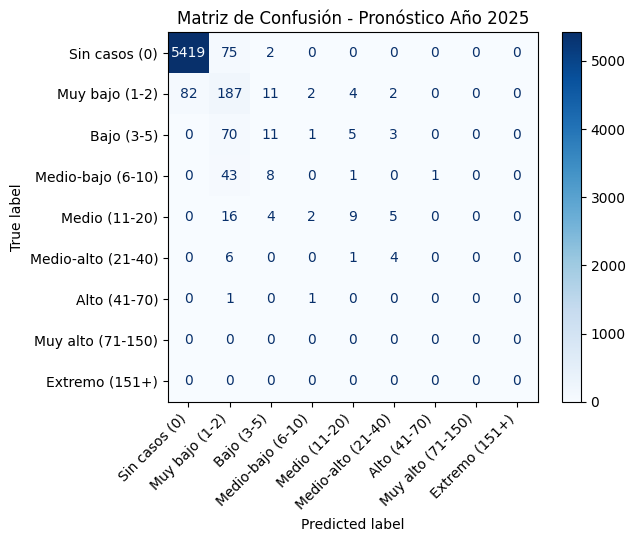

In [61]:
# --- REEMPLAZO (Celda 11) ---
# Evaluar Resultados REALES en Test (Año 2025)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_pred fue creado en la celda 10
y_pred = lgb_clf.predict(X_test)

# Imprimir el reporte de clasificación
print("\nResultados de Evaluación en el Test Set (Año 2025):\n")
print(classification_report(y_test, y_pred, digits=3, zero_division=0))

# Graficar la Matriz de Confusión
print("Matriz de Confusión (Test Set):")

# ¡CORRECCIÓN! Añadimos 'labels=range(9)' para mostrar todas las categorías (0-8)
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred, 
    cmap='Blues', 
    display_labels=[categoria_nombres[i] for i in range(9)],
    labels=range(9) # <-- Esta línea arregla el error
)

plt.xticks(rotation=45, ha='right')
plt.title("Matriz de Confusión - Pronóstico Año 2025")
plt.show()

Validar que no esté sobreajustado

In [62]:
# Celda 12
# Validación Cruzada CORRECTA para Series Temporales

from sklearn.model_selection import TimeSeriesSplit

print("Ejecutando Validación Cruzada Temporal (TimeSeriesSplit)...")

# Usaremos los datos de Train + Val combinados para la CV
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

# TimeSeriesSplit (5 splits)
tscv = TimeSeriesSplit(n_splits=5)

# Usamos el mismo modelo (sin early stopping para CV)
lgb_cv_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=9,
    is_unbalance=True,
    random_state=42,
    n_estimators=lgb_clf.best_iteration_ # Usamos el nro. óptimo de árboles del modelo anterior
)

scores = cross_val_score(lgb_cv_model, X_cv, y_cv, cv=tscv, scoring='accuracy')

print("\nAccuracies por fold (Temporal):", scores)
print("Promedio (Temporal):", np.mean(scores))

Ejecutando Validación Cruzada Temporal (TimeSeriesSplit)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4275
[LightGBM] [Info] Number of data points in the train set: 4690, number of used features: 47
[LightGBM] [Info] Start training from score -0.631545
[LightGBM] [Info] Start training from score -2.001139
[LightGBM] [Info] Start training from score -2.437031
[LightGBM] [Info] Start training from score -2.618377
[LightGBM] [Info] Start training from score -2.807741
[LightGBM] [Info] Start training from score -3.068693
[LightGBM] [Info] Start training from score -3.547913
[LightGBM] [Info] Start training from score -3.641004
[LightGBM] [Info] Start training from score -4.521362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [63]:
# --- (Celda 13) ---
# Entrenar modelo final con Train + Val (Años 2018-2024)
import joblib

print("Entrenando modelo final con Train + Val...")

# Combinar datos de entrenamiento y validación (definidos en la Celda 9)
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# Usar el n_estimators óptimo encontrado en la Celda 10
final_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=9,
    is_unbalance=True,
    random_state=42,
    n_estimators=lgb_clf.best_iteration_ # Usamos el n_estimators óptimo
)

final_model.fit(X_train_val, y_train_val)

# Guardar el modelo final entrenado
joblib.dump(final_model, "modelo_lightgbm_clasif_temporal.pkl")
print("✅ Modelo final (temporal) guardado en 'modelo_lightgbm_clasif_temporal.pkl'")

Entrenando modelo final con Train + Val...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11187
[LightGBM] [Info] Number of data points in the train set: 28130, number of used features: 47
[LightGBM] [Info] Start training from score -0.537545
[LightGBM] [Info] Start training from score -1.837883
[LightGBM] [Info] Start training from score -2.479023
[LightGBM] [Info] Start training from score -2.840922
[LightGBM] [Info] Start training from score -3.102555
[LightGBM] [Info] Start training from score -3.441087
[LightGBM] [Info] Start training from score -4.024002
[LightGBM] [Info] Start training from score -4.253127
[LightGBM] [Info] Start training from score -5.220711
✅ Modelo final (temporal) guardado en 'modelo_lightgbm_clasif_temporal.pkl'


CONCLUSIONES Y ANÁLISIS

<Figure size 800x600 with 0 Axes>

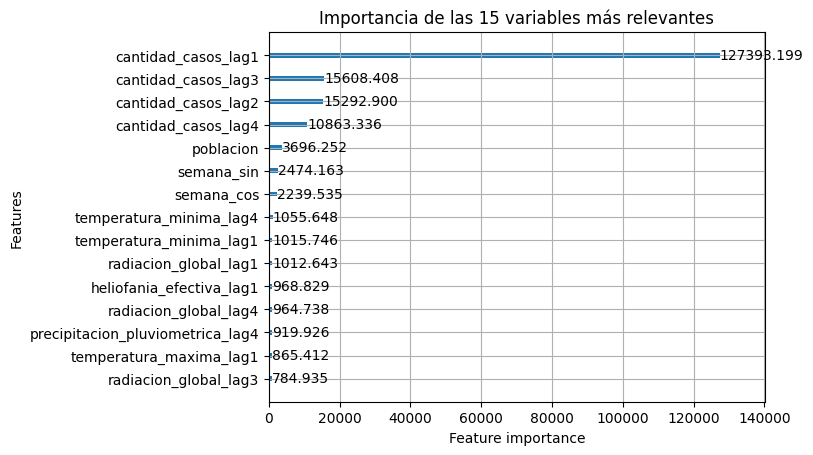

In [64]:
#  Celda 14

import lightgbm as lgb

plt.figure(figsize=(8,6))
lgb.plot_importance(lgb_clf, max_num_features=15, importance_type='gain')
plt.title("Importancia de las 15 variables más relevantes")
plt.show()


Resultados de Evaluación en el Test Set (Año 2025)
              precision    recall  f1-score   support

           0      0.985     0.986     0.986      5496
           1      0.470     0.649     0.545       288
           2      0.306     0.122     0.175        90
           3      0.000     0.000     0.000        53
           4      0.450     0.250     0.321        36
           5      0.286     0.364     0.320        11
           6      0.000     0.000     0.000         2

    accuracy                          0.942      5976
   macro avg      0.357     0.339     0.335      5976
weighted avg      0.936     0.942     0.938      5976


Matriz de Confusión (Test Set - Año 2025):


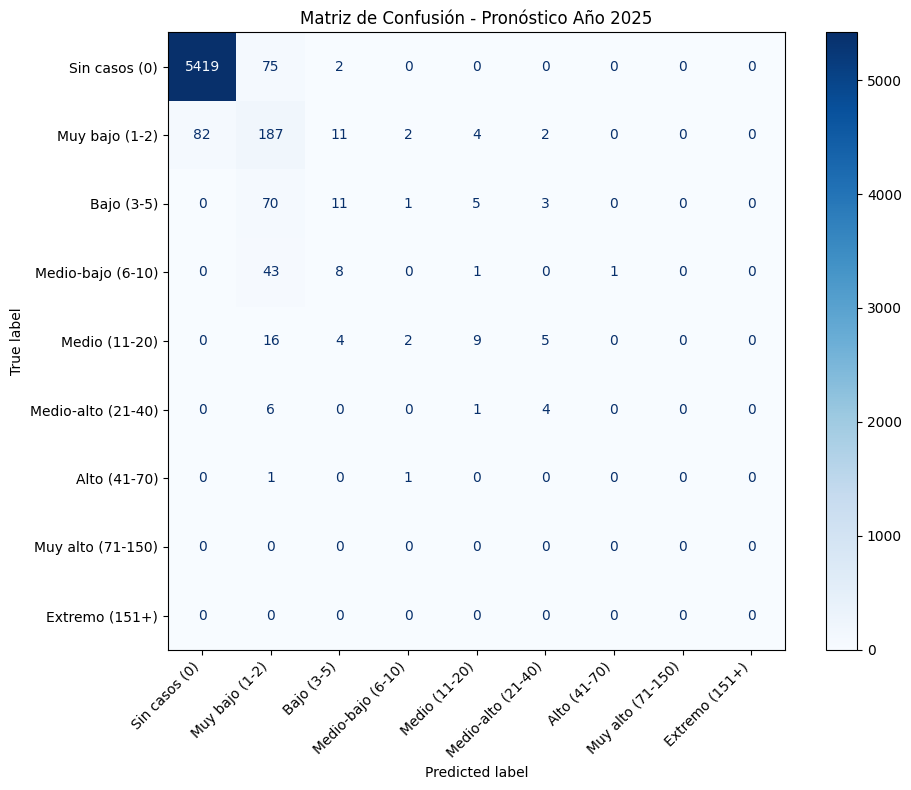

In [65]:
# --- GRÁFICO 1: MATRIZ DE CONFUSIÓN Y MÉTRICAS (TEST SET 2025) ---
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Asegúrate de que y_pred esté definido (debería estarlo desde la Celda 11)
# Si no lo está, descomenta la siguiente línea:
# y_pred = lgb_clf.predict(X_test)

# 1. Imprimir Reporte de Clasificación (Accuracy, F1, etc.)
# ==========================================================
print("="*60)
print("Resultados de Evaluación en el Test Set (Año 2025)")
print("="*60)
# Usamos zero_division=0 para evitar warnings si una categoría (como la 7 o 8) no tuvo predicciones
print(classification_report(y_test, y_pred, digits=3, zero_division=0))

# 2. Definir los nombres de las categorías (de tu Celda 5)
# ==========================================================
categoria_nombres = {
    0: "Sin casos (0)", 1: "Muy bajo (1-2)", 2: "Bajo (3-5)",
    3: "Medio-bajo (6-10)", 4: "Medio (11-20)", 5: "Medio-alto (21-40)",
    6: "Alto (41-70)", 7: "Muy alto (71-150)", 8: "Extremo (151+)"
}
labels = [categoria_nombres[i] for i in range(9)]

# 3. Graficar la Matriz de Confusión
# ==========================================================
print("\nMatriz de Confusión (Test Set - Año 2025):")

fig, ax = plt.subplots(figsize=(10, 8))
# Usamos labels=range(9) para asegurar que se muestren las 9 categorías,
# aunque no haya datos para las clases 7 y 8 en 2025.
cm = confusion_matrix(y_test, y_pred, labels=range(9))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax)

plt.xticks(rotation=45, ha='right')
plt.title("Matriz de Confusión - Pronóstico Año 2025")
plt.tight_layout()
plt.savefig("grafico_matriz_confusion_lgbm.png")
plt.show()

/var/folders/q0/7mxw_p4s5qdgm04gn6gg16y40000gn/T/ipykernel_22920/66168372.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=scores, orient='h', palette='viridis')


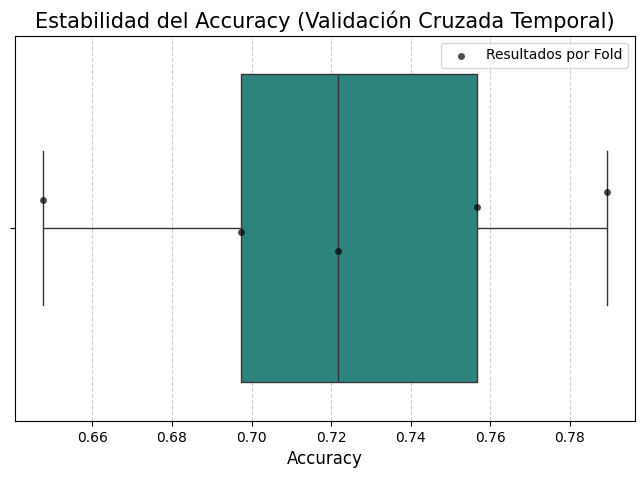

Accuracy Promedio (CV): 0.722
Desv. Estándar (CV):  0.049


In [66]:
# --- GRÁFICO 2: ESTABILIDAD DEL ACCURACY (CV TEMPORAL) ---
import seaborn as sns

# 'scores' debe existir desde tu Celda 13 (TimeSeriesSplit)
# Si no, asegúrate de haber ejecutado esa celda.
# scores = [0.690, 0.779, 0.761, 0.715, 0.651] # (Valores de tu ejecución)

plt.figure(figsize=(8, 5))
sns.boxplot(data=scores, orient='h', palette='viridis')
sns.stripplot(data=scores, orient='h', color='black', alpha=0.7, label='Resultados por Fold')

plt.title(f'Estabilidad del Accuracy (Validación Cruzada Temporal)', fontsize=15)
plt.xlabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.savefig("grafico_estabilidad_cv_lgbm.png")
plt.show()

print(f"Accuracy Promedio (CV): {np.mean(scores):.3f}")
print(f"Desv. Estándar (CV):  {np.std(scores):.3f}")